In [2]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [3]:
import os
import IPython
import keras_tuner as kt
import librosa as lr
import numpy as np
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import time

LOG_DIR = f'{int(time.time())}'

path = 'C:/Users/erikv/Desktop/IP/samples/' 
dirs = os.listdir(path)
#IPython.display.display(IPython.display.Audio(path+dirs[3],rate=sroriginal))

def rosaspec(sound, NFFT):
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT):
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]
#use a rectangular window.

In [4]:
NFFT = int(1021/2)
yoriginal1,sroriginal1 = lr.load(path+dirs[9],sr=2000)
originalspect = lr.stft(yoriginal1, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal1,NFFT)])
test = asignal/asignal.max()

print (test.shape)

(1, 256, 32, 2)


In [5]:
batchsize = 10 #len(dirs)
processed = np.zeros([batchsize, 256, 32, 2])
for i in range(batchsize):
    yoriginal,sroriginal = lr.load(path+dirs[i],sr=2000)
    originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    asignal = np.array([rosaspec(yoriginal,NFFT)])
    audio = asignal/asignal.max()
    processed[i] = audio

print (audio.shape,processed.shape)

(1, 256, 32, 2) (10, 256, 32, 2)


In [6]:
device = 'cuda'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(test[0,66,26,0])
print(processed[9,66,26,0])

Num GPUs Available:  1
-1.824749499151583e-06
-1.824749499151583e-06


In [7]:
input_shape = (processed.shape)
inp = (input_shape[1],input_shape[2],input_shape[3])
def build_model(hp):
    model = keras.models.Sequential()
    model.add(Conv2D(hp.Int("input_units",4,64,4), (3,3), activation='LeakyReLU', padding='same', input_shape=(inp)))

    model.add(Conv2D(hp.Int("1layer",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(hp.Int("2layer",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(hp.Int("3layer",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(hp.Int("4layer",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(hp.Int("layer1",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(hp.Int("layer2",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(hp.Int("layer3",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(hp.Int("layer4",4,64,4),(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    
    model.add(Conv2D(2,(3,3),activation='LeakyReLU', padding='same'))

    model.compile(optimizer='adam', 
                  loss='mean_absolute_percentage_error',
                  metrics=['accuracy'])

    return model

In [8]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 1,
    executions_per_trial = 100,
    directory = LOG_DIR)

tuner.search(x = processed,
             y = processed,
            epochs = 1,
            batch_size = 10,
            validation_data = (test,test))



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
input_units       |8                 |?                 
1layer            |28                |?                 
2layer            |52                |?                 
3layer            |60                |?                 
4layer            |28                |?                 
layer1            |64                |?                 
layer2            |8                 |?                 
layer3            |48                |?                 
layer4            |44                |?                 

1/1 [==============================] - 1s 1s/step - loss: 30302.6035 - accuracy: 0.5179 - val_loss: 593451.1875 - val_accuracy: 0.4504


KeyboardInterrupt: 

In [11]:
print(tuner.results_summary())

Results summary
Results in 1643762867\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 60
1layer: 16
2layer: 12
3layer: 16
4layer: 56
layer1: 28
layer2: 24
layer3: 16
layer4: 60
Score: 0.50447265625
None


In [12]:
print(tuner.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 32, 60)       1140      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 32, 16)       8656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 16, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 16, 12)       1740      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 8, 12)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 8, 16)         1744      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 4, 16)         0

In [9]:
def build_model_tuned(x,a1,a2,a3,a4,b1,b2,b3,b4):
    model = keras.models.Sequential()
    model = keras.models.Sequential()
    model.add(Conv2D(x, (3,3), activation='LeakyReLU', padding='same', input_shape=(inp)))

    model.add(Conv2D(a1,(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(a2,(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(a3,(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(a4,(3,3),activation='LeakyReLU', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(b1,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(b2,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(b3,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(b4,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2,2)))
    
    model.add(Conv2D(2,(3,3),activation='LeakyReLU', padding='same'))

    model.compile(optimizer='adam', 
                  loss='mean_absolute_percentage_error',
                  metrics=['accuracy'])

    return model

In [10]:
print(tuner.get_best_hyperparameters()[0].values)

IndexError: list index out of range

In [11]:
autoencoder = build_model_tuned(256,256,512,512,1024,1024,512,512,256)
print(autoencoder.summary())
print(tuner.get_best_models()[0].summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 32, 256)      4864      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 32, 256)      590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 16, 256)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 16, 512)      1180160   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 8, 512)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 8, 512)        2359808   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 4, 512)       

IndexError: list index out of range

In [14]:
autoencoder.fit(processed,processed,
                epochs=10,
                batch_size=1,
                shuffle=False,
                validation_data=(test,test))

Epoch 1/10
10/10 [==============================] - 1s 81ms/step - loss: 507569.5938 - accuracy: 0.5000 - val_loss: 335220.2500 - val_accuracy: 0.5247
Epoch 2/10
10/10 [==============================] - 1s 76ms/step - loss: 185557.9688 - accuracy: 0.4972 - val_loss: 149736.5625 - val_accuracy: 0.4673
Epoch 3/10
10/10 [==============================] - 1s 76ms/step - loss: 133767.0312 - accuracy: 0.4970 - val_loss: 147108.9375 - val_accuracy: 0.4563
Epoch 4/10
10/10 [==============================] - 1s 76ms/step - loss: 160281.7344 - accuracy: 0.4934 - val_loss: 147319.3906 - val_accuracy: 0.5491
Epoch 5/10
10/10 [==============================] - 1s 76ms/step - loss: 156965.2031 - accuracy: 0.4955 - val_loss: 178871.2500 - val_accuracy: 0.5455
Epoch 6/10
10/10 [==============================] - 1s 77ms/step - loss: 103870.7031 - accuracy: 0.5040 - val_loss: 93783.3672 - val_accuracy: 0.4894
Epoch 7/10
10/10 [==============================] - 1s 77ms/step - loss: 79661.9766 - accuracy:

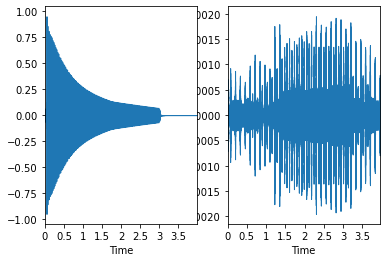

4.904363271025028e-07
0.014672095


In [13]:
decoded_array = autoencoder.predict(processed)[9]
decoded_audio = irosaspec(decoded_array,NFFT)

enprobe = rosaspec(yoriginal1, NFFT)
deprobe = irosaspec(enprobe,NFFT)

#noisy = yoriginal+np.random.normal(0,0.01,64000)
#ennoisy = rosaspec(noisy, NFFT)
#denoisy = irosaspec(ennoisy,NFFT)

plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=decoded_audio,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal)
plt.show()

#IPython.display.display(IPython.display.Audio(file))
IPython.display.display(IPython.display.Audio(deprobe,rate = sroriginal))
#IPython.display.display(IPython.display.Audio(noisy,rate=sroriginal))
#IPython.display.display(IPython.display.Audio(denoisy,rate=sroriginal))
IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal))

print(test[0,66,26,1])
print(decoded_array[66,26,1])

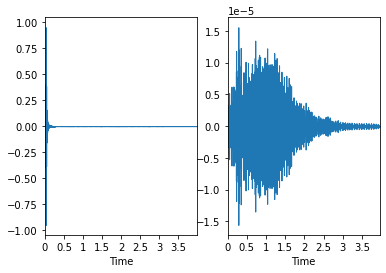

In [24]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 13

b, a = butter_lowpass(cutoff, fs, order)

filtered1 = butter_lowpass_filter(yoriginal1, cutoff, fs, order)
filtered = butter_lowpass_filter(decoded_audio, cutoff, fs, order)
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=filtered,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal)
plt.show()

IPython.display.display(IPython.display.Audio(yoriginal1,rate=sroriginal))
IPython.display.display(IPython.display.Audio(filtered,rate=sroriginal))

In [102]:
audio.max(), audio.min()

(1.0, -0.856759766190995)

In [89]:
print(yoriginal.shape)
print(enprobe.shape)
print(deprobe.shape)
print(decoded_array.shape)
print(decoded_audio.shape)



(64000,)
(504, 128, 2)
(63881,)
(504, 128, 2)
(63881,)


(1.0, -0.7587283885818327)

In [81]:
i = 2
j = 4
while i<25600/2:
    NFFT = i
    file = 'C:/Users/erikv/Desktop/IP/samples/bass_electronic_027-056-050.wav'

    yoriginal,sroriginal = lr.load(file,sr=None)
    orginalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    audio = np.array([rosaspec(yoriginal,NFFT)])

    numbers = audio.shape
    x = numbers[1]
    y = numbers[2]
    if x%j == 0 and y%j == 0:
            print (i)
    i=i+2

110
126
134
166
174
182
254
286
294
302
334
382
406
422
478
486
494
518
526
534
582
606
630
654
670
766
782
822
846
870
894
918
942
974
1006
1038
1070
1110
1150
1190
1238
1286
1334
1342
1398
1406
1462
1470
1526
1534
1542
1606
1614


KeyboardInterrupt: 

<IPython.core.display.Javascript object>